In [19]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [20]:
# !conda install -n propulsion pyarrow -y

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
df_finances = pd.read_csv("../data/processed/mevluet_data_merged.csv", index_col=0)

In [23]:
# Collected using the Yahoo Finance API
df_prices = pd.read_parquet("../data/raw/stock_closes.pq")

In [24]:
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11543 entries, 1990-01-02 to 2021-08-09
Columns: 7073 entries, A to YFI-USD
dtypes: float32(7073)
memory usage: 311.5 MB


In [25]:
df_finances.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19794 entries, 0 to 19793
Data columns (total 87 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Ticker                                           19794 non-null  object 
 1   SimFinId_x                                       19794 non-null  int64  
 2   Currency_x                                       19794 non-null  object 
 3   Fiscal Year                                      19794 non-null  int64  
 4   Fiscal Period_x                                  19794 non-null  object 
 5   Report Date_x                                    19794 non-null  object 
 6   Publish Date_x                                   19794 non-null  object 
 7   Restated Date_x                                  19794 non-null  object 
 8   Shares (Basic)_x                                 19667 non-null  float64
 9   Shares (Diluted)_x          

In [26]:
df_finances_2005 = df_finances[df_finances["Fiscal Year"] == 2005]

In [27]:
# get price data for 2005 companies in financial dataset

tickers_2005 = set(df_finances_2005["Ticker"])

tickers_prices = set(df_prices.columns)

In [28]:
# check if tickers matches between two datasets

tickers_2005 - tickers_prices
# CGRN not in the price dataset

df_finances_2005 = df_finances_2005[df_finances_2005["Ticker"] != "CGRN"]

tickers_2005 = tickers_2005 - {"CGRN"}
len(tickers_2005)

50

In [53]:
prices_2005 = df_prices.loc[:, tickers_2005]
prices_2005 = prices_2005["2005-01-01":"2012-12-31"]
prices_2005.shape

(2922, 50)

In [54]:
# scale to the price on 2005-01-01
# i.e., all prices=1 on 2005-01-01

prices_2005_scaled = prices_2005 / prices_2005.iloc[0]

<AxesSubplot:xlabel='Date'>

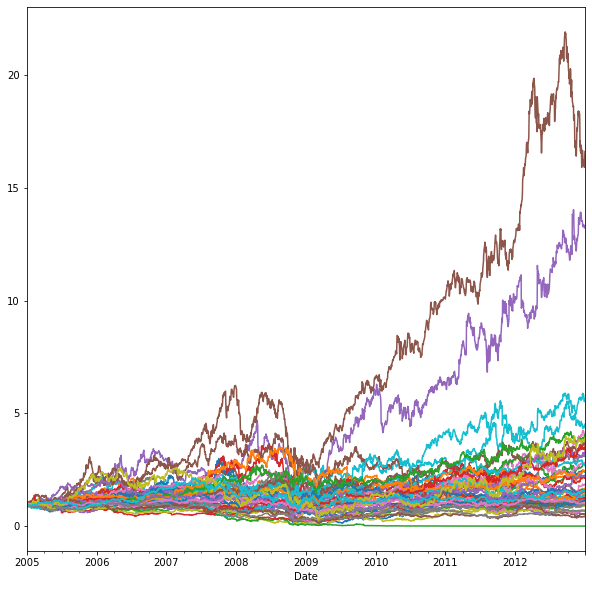

In [55]:
prices_2005_scaled.plot(figsize=(10, 10), legend=False)

<AxesSubplot:>

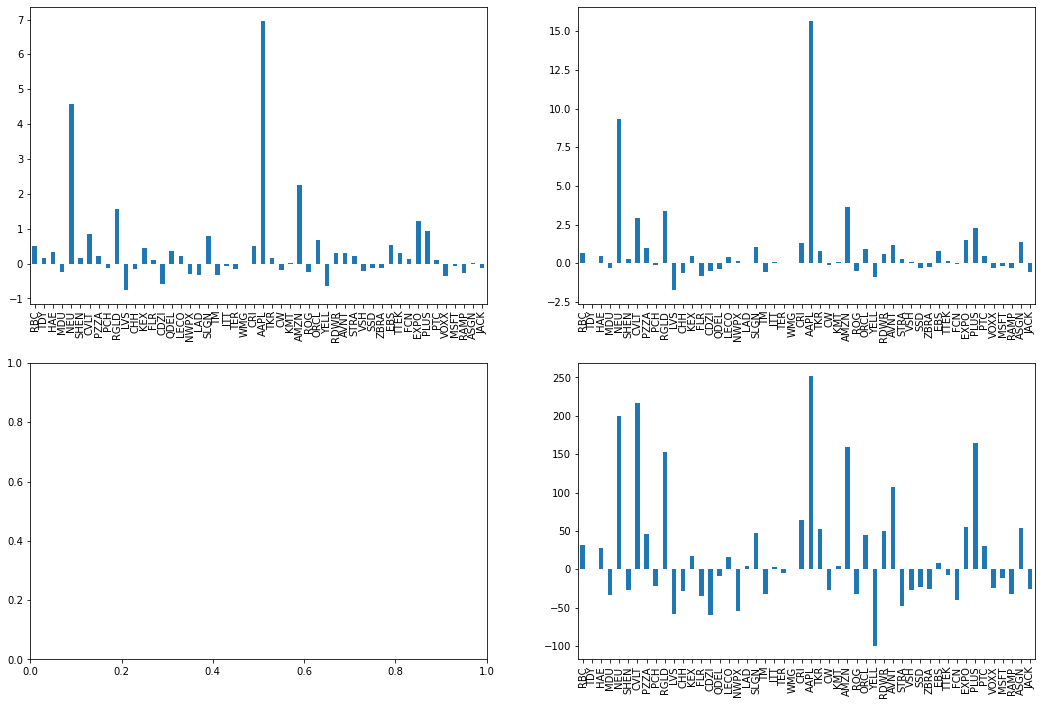

In [91]:
# Bankrupty of Lehman Brothers 2008-09-15

# mean
mean_before = prices_2005_scaled.loc[:"2008-09-15", :].mean()
mean_after = prices_2005_scaled.loc["2008-09-15":, :].mean()

# max
max_before = prices_2005_scaled.loc[:"2008-09-15", :].max()
max_after = prices_2005_scaled.loc["2008-09-15":, :].max()
max_2012 = prices_2005_scaled.loc["2012-01-01":, :].max()

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
(mean_after - mean_before).plot.bar(ax=axes[0, 0])
(max_after - max_before).plot.bar(ax=axes[0, 1])
(100 * (max_2012 - max_before) / max_before).plot.bar(ax=axes[1, 1])

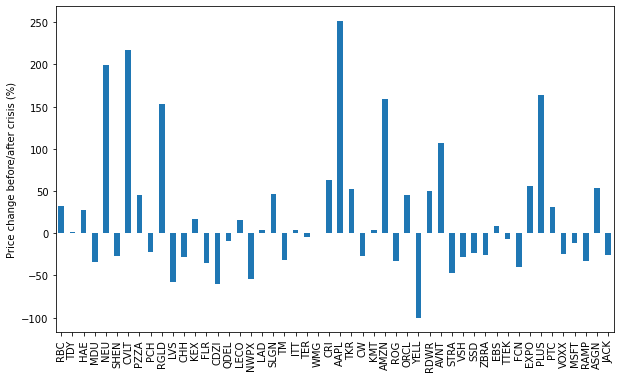

In [96]:
# replot more cleary
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
percentage_change = 100 * (max_2012 - max_before) / max_before
percentage_change.plot.bar(ax=ax)
ax.set(ylabel="Price change before/after crisis (%)")
plt.savefig("../figures/price_chance.pdf", bbox_inches="tight")
plt.show()

In [81]:
# binary indicator on whether company "survived" the 2008 financial crisis

# mask = max_after > max_before
mask = max_2012 > max_before
# mask = ~(max_2012 < 0.5 * max_before)
tickers_survived = set(max_after[mask].index)
tickers_died = set(max_after[~mask].index)

In [82]:
print(len(tickers_survived))
tickers_survived

25


{'AAPL',
 'AMZN',
 'ASGN',
 'AVNT',
 'CRI',
 'CVLT',
 'EBS',
 'EXPO',
 'HAE',
 'ITT',
 'KEX',
 'KMT',
 'LAD',
 'LECO',
 'NEU',
 'ORCL',
 'PLUS',
 'PTC',
 'PZZA',
 'RBC',
 'RDWR',
 'RGLD',
 'SLGN',
 'TDY',
 'TKR'}

In [83]:
print(len(tickers_died))
tickers_died

25


{'CDZI',
 'CHH',
 'CW',
 'FCN',
 'FLR',
 'JACK',
 'LVS',
 'MDU',
 'MSFT',
 'NWPX',
 'PCH',
 'QDEL',
 'RAMP',
 'ROG',
 'SHEN',
 'SSD',
 'STRA',
 'TER',
 'TM',
 'TTEK',
 'VOXX',
 'VSH',
 'WMG',
 'YELL',
 'ZBRA'}

In [84]:
df_finances_from2005 = df_finances[df_finances["Ticker"].isin(tickers_2005)]

df_finances_from2005["survived"] = (
    df_finances_from2005["Ticker"]
    .apply(lambda tick: 1 if tick in tickers_survived else 0)
    .astype("category")
)

/var/folders/57/h9v24nzx4pj9gx46p1yhvwxm0000gn/T/ipykernel_47179/294692329.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_finances_from2005["survived"] = (


In [85]:
# check if number of tickers is correct

print(
    len(
        df_finances_from2005.loc[
            df_finances_from2005["survived"] == 1, "Ticker"
        ].unique()
    )
)
print(
    len(
        df_finances_from2005.loc[
            df_finances_from2005["survived"] == 0, "Ticker"
        ].unique()
    )
)

25
25


In [86]:
df_finances_from2005.to_csv("../data/processed/financial_data_with_survival_info.csv")

In [87]:
df_finances_from2005.head()

,Ticker,SimFinId_x,Currency_x,Fiscal Year,Fiscal Period_x,Report Date_x,Publish Date_x,Restated Date_x,Shares (Basic)_x,Shares (Diluted)_x,...,Cash from (Repayment of) Debt,Cash from (Repurchase of) Equity,Net Cash from Financing Activities,Net Change in Cash,SimFinId_y.1,Company Name,IndustryId,Sector,Industry,survived
302,QDEL,1055094,USD,1999,Q4,1999-12-31,2001-04-02,2001-04-02,29964000.0,30272000.0,...,11507000.0,738000.0,11025000.0,-1340000,1055094,QUIDEL CORP /DE/,106001.0,Healthcare,Medical Diagnostics & Research,0
303,QDEL,1055094,USD,2000,Q4,2000-12-31,2001-02-14,2002-03-29,29964000.0,30272000.0,...,-2053000.0,2907000.0,854000.0,-2771000,1055094,QUIDEL CORP /DE/,106001.0,Healthcare,Medical Diagnostics & Research,0
304,QDEL,1055094,USD,2001,Q4,2001-12-31,2002-03-29,2003-03-31,29964000.0,30272000.0,...,-670000.0,1812000.0,1142000.0,1495000,1055094,QUIDEL CORP /DE/,106001.0,Healthcare,Medical Diagnostics & Research,0
305,QDEL,1055094,USD,2002,Q4,2002-12-31,2003-03-31,2004-03-15,29964000.0,30272000.0,...,-3078000.0,780000.0,-2298000.0,-486000,1055094,QUIDEL CORP /DE/,106001.0,Healthcare,Medical Diagnostics & Research,0
306,QDEL,1055094,USD,2003,Q4,2003-12-31,2004-03-15,2005-03-16,29964000.0,30272000.0,...,-454000.0,6479000.0,6025000.0,22717000,1055094,QUIDEL CORP /DE/,106001.0,Healthcare,Medical Diagnostics & Research,0


In [88]:
# Clean and rename columns

df_finances_from2005 = pd.read_csv(
    "../data/processed/financial_data_with_survival_info.csv", index_col=0
)

columns = df_finances_from2005.columns
drop_cols = [
    col
    for col in columns
    if (("_y" in col) or ("SimFinId" in col) or col.endswith(".1"))
]
rename_cols = {col: col.replace("_x", "") for col in columns if "_x" in col}

df_finances_from2005.drop(columns=drop_cols, inplace=True)
df_finances_from2005.rename(columns=rename_cols, inplace=True)

# for col in df_finances_from2005.columns:
#     print(col)

df_finances_from2005.to_csv("../data/processed/financial_data_with_survival_info.csv")

<AxesSubplot:xlabel='Date'>

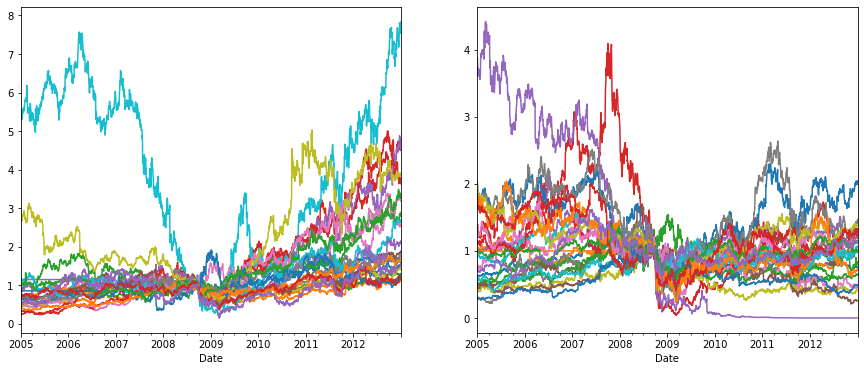

In [89]:
# check price records for survived/died companies

prices_2005_scaled_crisis = prices_2005 / prices_2005.loc["2008-09-15"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
prices_2005_scaled_crisis[tickers_survived].plot(ax=ax1, legend=False)
prices_2005_scaled_crisis[tickers_died].plot(ax=ax2, legend=False)